In [1]:
import h5py
import numpy as np
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, GlobalAveragePooling2D, add, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from PIL import Image
import pathlib
import os

# Pre-Processing

In [ ]:
# To get the images and labels from file
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
#labels = utils.to_categorical(labels, 10)

In [3]:
images.shape

(17736, 256, 256, 3)

In [94]:
labels.shape

(17736,)

In [114]:
np.where(labels==0)[0]

array([   0,    1,    2, ..., 1078, 1079, 1080], dtype=int64)

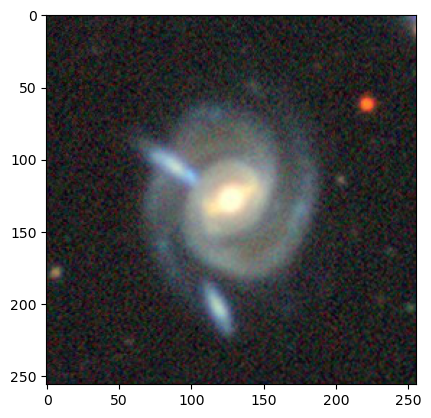

In [87]:
i=int(np.random.rand(1)*images.shape[0]) #8971
plt.imshow(images[i])
plt.show()

In [6]:
n_c=[]
for c in range(0,10):
    c_n = 0
    for i in range(len(labels)):
        if labels[i][c]==1: c_n+=1
    n_c.append(c_n)
n_c

[1081, 1853, 2645, 2027, 334, 2043, 1829, 2628, 1423, 1873]

In [21]:
labels_n=['Disturbed Galaxies','Merging Galaxies','Round Smooth Galaxies','In-between Round Smooth Galaxies',
         'Cigar Shaped Smooth Galaxies','Barred Spiral Galaxies','Unbarred Tight Spiral Galaxies',
         'Unbarred Loose Spiral Galaxies','Edge-on Galaxies without Bulge','Edge-on Galaxies with Bulge']

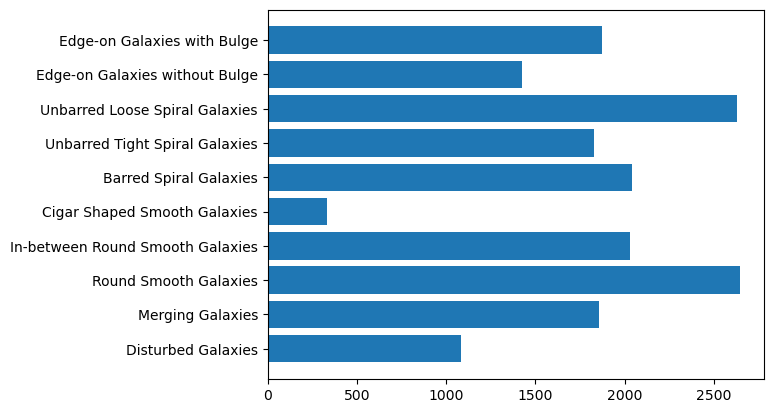

In [7]:
fig= plt.figure(fig)
plt.barh(labels_n, n_c)
plt.yticks(labels_n)
plt.show()

In [41]:
zip_ = zip(labels_n,n_c)
N_labels = dict(zip_)
N_labels

{'Disturbed Galaxies': 1081,
 'Merging Galaxies': 1853,
 'Round Smooth Galaxies': 2645,
 'In-between Round Smooth Galaxies': 2027,
 'Cigar Shaped Smooth Galaxies': 334,
 'Barred Spiral Galaxies': 2043,
 'Unbarred Tight Spiral Galaxies': 1829,
 'Unbarred Loose Spiral Galaxies': 2628,
 'Edge-on Galaxies without Bulge': 1423,
 'Edge-on Galaxies with Bulge': 1873}

In [28]:
cats = [[],[],[],[],[],[],[],[],[],[]]
for i in range (0,10):
    cats[i] = images[np.where(labels==i)[0][0]:np.where(labels==i)[0][-1]+1]

labs_names = ['Dist','Merg','Rou','In_Rou','Cig','Bar','NBarT','NBarL','NBul','Bul']

In [30]:
def DataPrePro(images, labels, labs_names):
    datagen = ImageDataGenerator(rotation_range=30,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')
    idx_cats = [-1]
    main_path = 'Images'
    os.mkdir(main_path)
    for i in range(0,10):
        idx_cats.append(np.where(labels==i)[0][-1])
        cat_path = labs_names[i]
        os.mkdir(main_path+'/'+cat_path)

        if (idx_cats[-1]-idx_cats[-2]) < 2000:
          aug_iter = datagen.flow(images[idx_cats[-2]+1:idx_cats[-1]],batch_size=1)
          for j in range(11):
            im = next(aug_iter)[0].astype('uint8')
            ima = Image.fromarray(im)
            ima.save(main_path+'/'+cat_path+'/'+str(j)+'.jpeg')
        else:
          newidxs = np.random.randint(idx_cats[-2]+1,idx_cats[-1]+1,size=2000)
          aug_iter = datagen.flow(images[newidxs],batch_size=1)
          for j in range(11):
            im = next(aug_iter)[0].astype('uint8')
            ima = Image.fromarray(im)
            ima.save(main_path+'/'+cat_path+'/'+str(j)+'.jpeg')

DataPrePro(images,labels,labs_names)


In [27]:
datagen = ImageDataGenerator(rotation_range=30,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

for j in range(1):
    os.mkdir(labels_n[j])
    if len(cats[j])>2000:
        continue
    else:
        aug_iter = datagen.flow(cats[j],batch_size=1)
        for i in range(11):
            im = next(aug_iter)[0].astype('uint8')
            ima = Image.fromarray(im)
            ima.save(labels_n[j]+'/'+str(i)+'.jpeg')

In [23]:
labels_n[0]+'/'

'Disturbed Galaxies/'

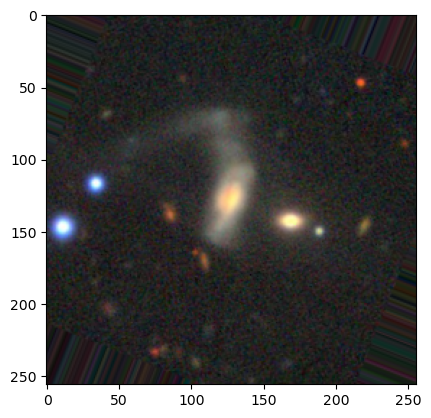

In [20]:
datagen = ImageDataGenerator(rotation_range=30,horizontal_flip=True, fill_mode='nearest')
aug_iter = datagen.flow(np.reshape(cats[0][0],(1,256,256,3)), batch_size=1)
im = next(aug_iter)[0].astype('uint8')
plt.imshow(im)

os.mkdir('Test')
ima = Image.fromarray(im)
ima.save("Test/test.jpeg")

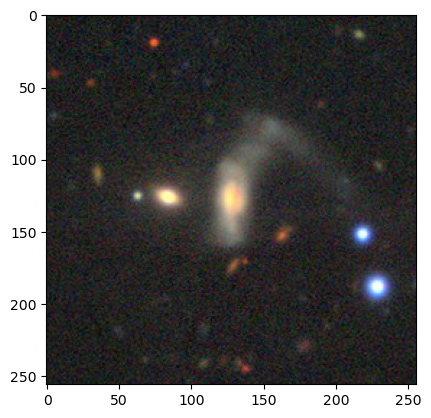

In [7]:
plt.imshow(cats[0][0])

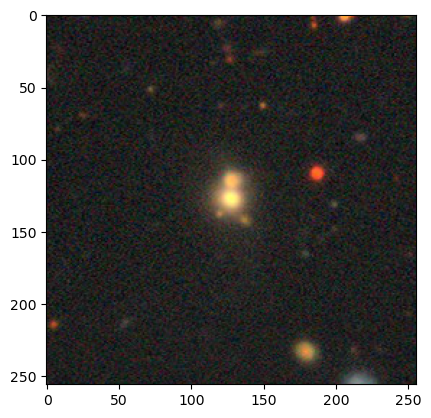

In [308]:
plt.imshow(cats[1][0].astype('uint8'))

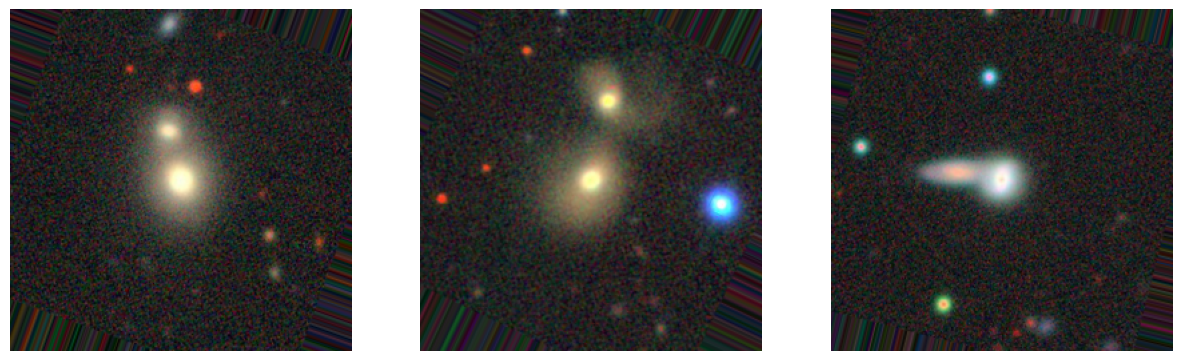

In [288]:
datagen = ImageDataGenerator(rotation_range=30,horizontal_flip=True, fill_mode='nearest')

# iterator
#for element in dataset.as_numpy_iterator():
#    aug_iter = datagen.flow(cats[0],batch_size=1)
#    break

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

# Conv-Dense

In [2]:
model = Sequential([
    Rescaling(1./255, input_shape=(256,256,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Conv2D(256, (3,3), activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

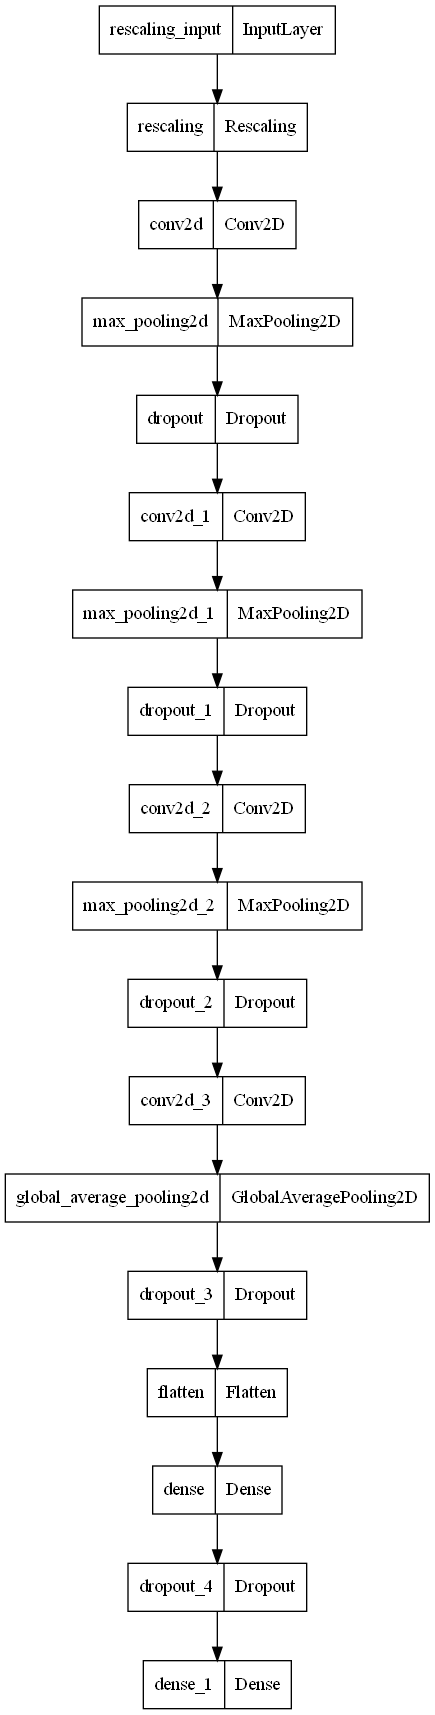

In [4]:
plot_model(model,to_file='CNN.png')

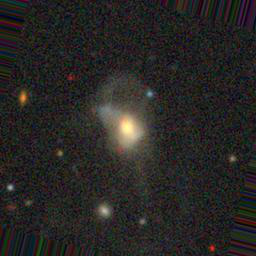

In [7]:
main_path = 'Images'
path = pathlib.Path(main_path)
dist = list(path.glob('Dist/*'))
Image.open(str(dist[7]))


In [8]:
batch_size, img_height, img_width = 32, 256, 256


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=0.2,
    subset='training',
    seed=17,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=0.2,
    subset='validation',
    seed=17,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 20010 files belonging to 10 classes.
Using 16008 files for training.
Found 20010 files belonging to 10 classes.
Using 4002 files for validation.


In [8]:
#train_ds = train_ds.repeat(count=3)

In [9]:
class_names = train_ds.class_names
print(class_names)

['Bar', 'Bul', 'Cig', 'Dist', 'In_Rou', 'Merg', 'NBarL', 'NBarT', 'NBul', 'Rou']


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
#os.mkdir('checkpoints')
checkpoint_filepath = 'checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

filename='log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [ ]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

history = model.fit(train_ds, validation_data = val_ds, epochs=15, verbose = 1, callbacks=[model_checkpoint_callback,history_logger])


Epoch 1/15
501/501 [==============================] - ETA: 0s - loss: 2.2129 - accuracy: 0.1405

In [11]:
# Keep training if kernel dies

new_model = load_model(checkpoint_filepath)
#assert_allclose(model.predict(x_train),
#                new_model.predict(x_train),
#                1e-5)

# fit the model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

new_model.fit(train_ds, validation_data = val_ds, epochs=10, steps_per_epoch=100, verbose = 1, callbacks=[model_checkpoint_callback,history_logger])

Epoch 1/10
 13/100 [==>...........................] - ETA: 2:28 - loss: 0.7992 - accuracy: 0.6851


KeyboardInterrupt



In [3]:
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1691740818538458498
xla_global_id: -1
]


In [8]:
100*5*32

16000

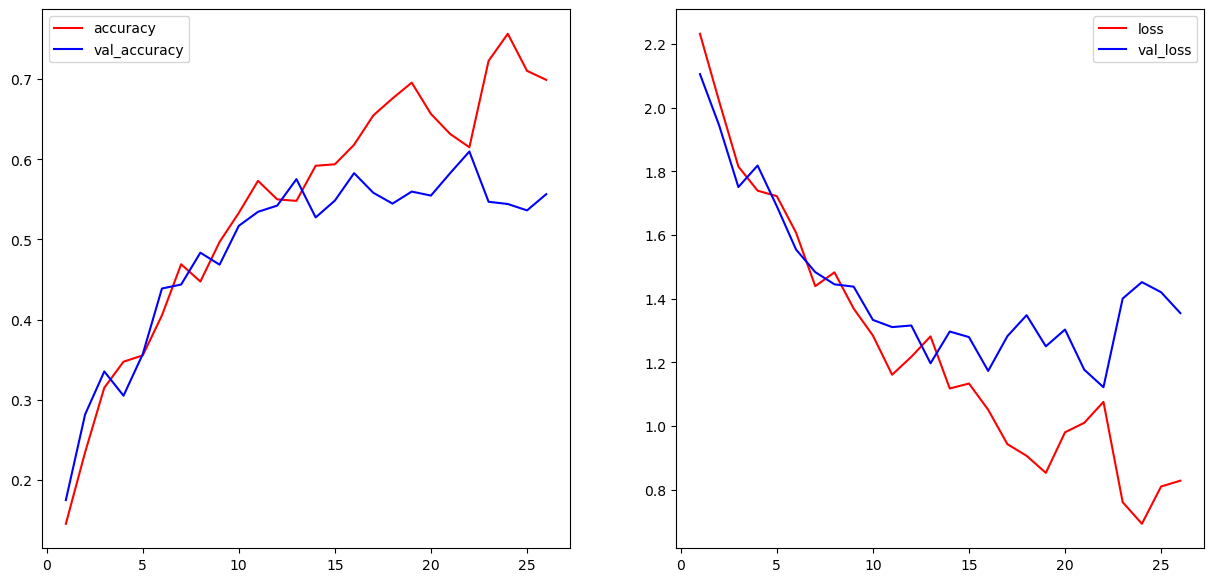

In [2]:
log = np.genfromtxt('2drop.25/log.csv',delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()

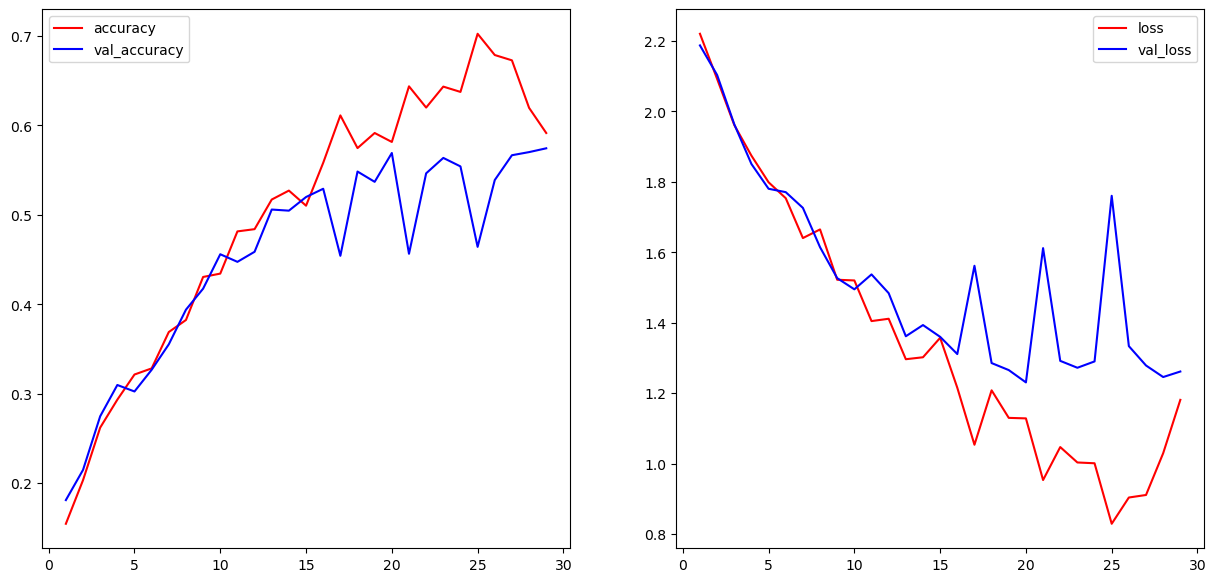

In [3]:
log = np.genfromtxt('log.csv',delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()

# ResNet

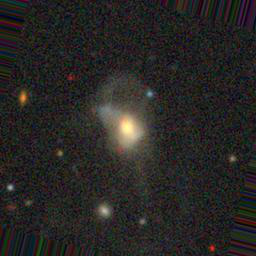

In [31]:
main_path = 'Images'
path = pathlib.Path(main_path)
dist = list(path.glob('Dist/*'))
Image.open(str(dist[7]))

In [4]:
batch_size, img_height, img_width = 32, 256, 256


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=0.2,
    subset='training',
    seed=17,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=0.2,
    subset='validation',
    seed=17,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 20010 files belonging to 10 classes.
Using 16008 files for training.
Found 20010 files belonging to 10 classes.
Using 4002 files for validation.


In [ ]:
def resc(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(resc)
val_ds = val_ds.map(resc)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 60:
        lr *= 1e-1
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 180:
        lr *= 0.5e-3
    print('Learning rate: {:e}'.format(lr))
    return lr

In [5]:
def resnet_layer(inputs, num_filters=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=True, conv_first=True):
    
    conv = Conv2D(num_filters,kernel_size=kernel_size,strides=strides,
                  padding='same') #,kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        x = BN_Act(x,batch_normalization,activation)
    else:
        x = BN_Act(x,batch_normalization,activation)
        x = conv(x)
    return x

def BN_Act(x,BN,act):
    if BN:
        x = BatchNormalization()(x)
    if act is not None:
        x = Activation(act)(x)
    return x

In [9]:
def resnet_v1(input_shape, depth, num_classes=10):
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs) # Se hace conv y BN a los datos originales (esto luego se suma) (?)
    
    num_stacks = 3            # con 4 se reduce hasta 32x32, más? menos? TBD
    
    for stack in range(num_stacks):
        for res_block in range(num_res_blocks):
            strides = 1
            
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,     # Kernel tamaño 1 para la reducción de dimensión
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    
    # Una capa dense antes de la clasificación? TBD #######################################################
    
    outputs = Dense(num_classes,activation='softmax')(y) #,kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
input_shape, depth = (256,256,3), 20

model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy'])
model.summary()
#plot_model(model, to_file="model.png", show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_50 (BatchN  (None, 256, 256, 16  64         ['conv2d_60[0][0]']              
 ormalization)                  )                                                           

In [46]:
# CALLBACKS

checkpoint_filepath = 'checkpoints'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


filename='log.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, cooldown=0, patience=3, min_lr=0.5e-6)

callbacks = [model_checkpoint_callback, history_logger, lr_reducer] #, lr_scheduler]

In [45]:
history = model.fit(train_ds, validation_data = val_ds, batch_size= batch_size, epochs=50, verbose = 1, callbacks=callbacks)

Epoch 1/15
 1/10 [==>...........................] - ETA: 6:10 - loss: 2.1742 - accuracy: 0.2500

KeyboardInterrupt: 

# Transfer Learning

In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# crea el modelo pre-entrenado base_model desde Keras
base_model = InceptionV3(weights='imagenet', include_top=False)

In [8]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [44]:
x = base_model.output

x = Dropout(.4)(x)
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(.4)(x)

predictions = Dense(10, activation='softmax')(x)

# Este es el modelo que entrenaremos
model = Model(inputs=base_model.input, outputs=predictions)

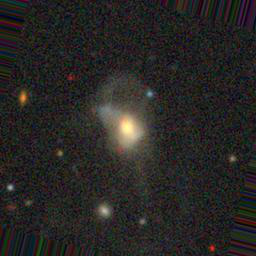

In [2]:
main_path = 'Images'
path = pathlib.Path(main_path)
dist = list(path.glob('Dist/*'))
Image.open(str(dist[7]))

In [3]:
batch_size, img_height, img_width = 32, 256, 256


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=0.2,
    subset='training',
    seed=17,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    main_path,
    validation_split=0.2,
    subset='validation',
    seed=17,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 20010 files belonging to 10 classes.
Using 16008 files for training.
Found 20010 files belonging to 10 classes.
Using 4002 files for validation.


In [4]:
def resc(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(resc)
val_ds = val_ds.map(resc)

In [5]:
train_ds = train_ds.repeat(count=2)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
# primero: entrena solo las capas superiores (que se inicializaron aleatoriamente)
# es decir, congelar todas las capas convolucionales de InceptionV3
for layer in base_model.layers:
    layer.trainable = False


# compilar el modelo (debe hacerse después de configurar las capas como no entrenables)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [46]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_81 (Conv2D)             (None, None, None,   864         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_69 (BatchN  (None, None, None,   96         ['conv2d_81[0][0]']              
 ormalization)                  32)                                                         

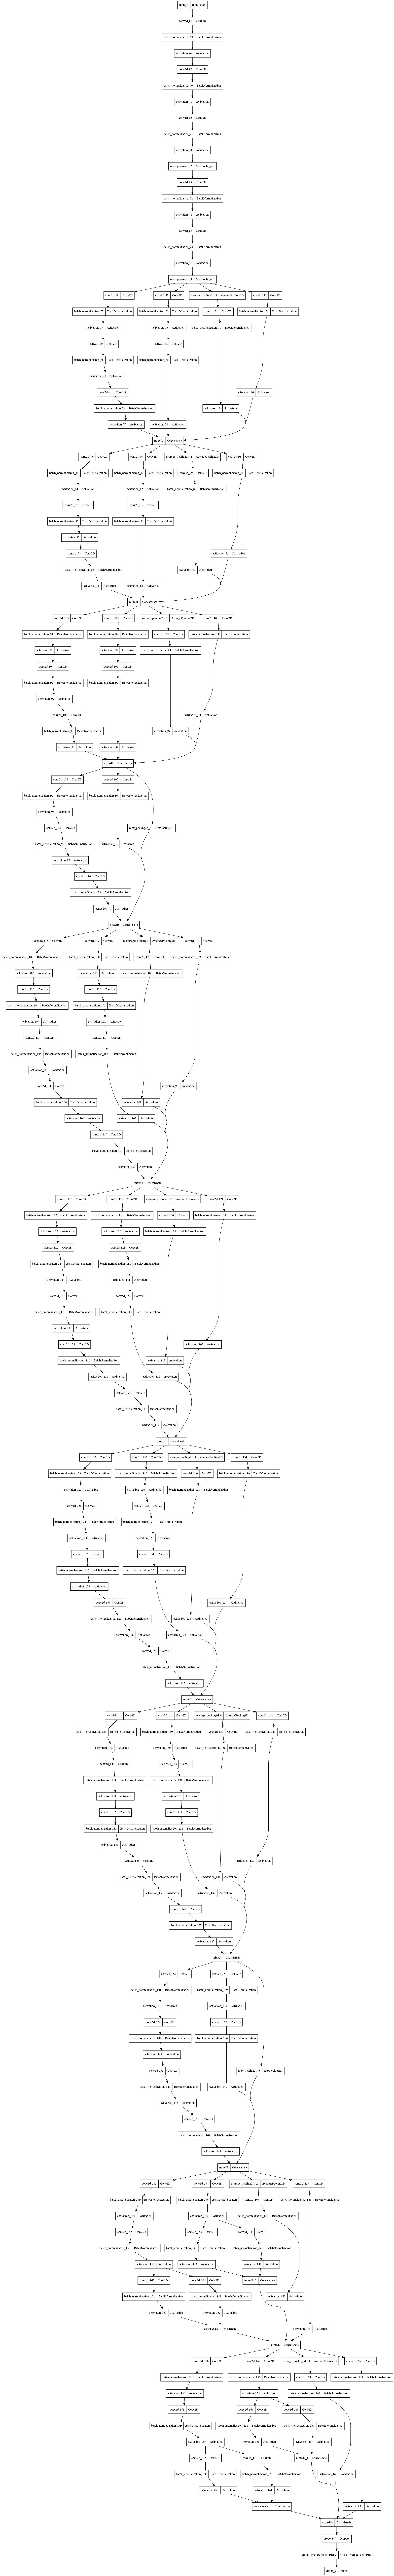

In [19]:
plot_model(model,to_file='TL.png')

In [7]:
# CALLBACKS

checkpoint_filepath = 'checkpoints_FT'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)


filename='log_FT.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

#lr_scheduler = LearningRateScheduler(lr_schedule)

#lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, cooldown=0, patience=3, min_lr=0.5e-6)

callbacks = [model_checkpoint_callback, history_logger] #, lr_reducer] #, lr_scheduler]

In [12]:
history_0 = model.fit(train_ds, validation_data = val_ds, epochs = 15, steps_per_epoch=300, verbose = 1, callbacks=callbacks)

Epoch 1/15
300/300 [==============================] - ETA: 0s - loss: 1.8221 - accuracy: 0.3431
Epoch 1: val_accuracy improved from -inf to 0.47251, saving model to checkpoints


INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


300/300 [==============================] - 877s 3s/step - loss: 1.8221 - accuracy: 0.3431 - val_loss: 1.4610 - val_accuracy: 0.4725
Epoch 2/15
300/300 [==============================] - ETA: 0s - loss: 1.5671 - accuracy: 0.4331

AbortedError: Graph execution error:

Detected at node 'model/activation_26/Relu' defined at (most recent call last):
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\elave\AppData\Local\Temp\ipykernel_17772\3674112194.py", line 1, in <cell line: 1>
      history_0 = model.fit(train_ds, validation_data = val_ds, epochs = 15, steps_per_epoch=300, verbose = 1, callbacks=callbacks)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\training.py", line 1445, in fit
      val_logs = self.evaluate(
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\layers\core\activation.py", line 57, in call
      return self.activation(inputs)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\activations.py", line 311, in relu
      return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
    File "C:\Users\elave\miniconda3\envs\testDipGal\lib\site-packages\keras\backend.py", line 4992, in relu
      x = tf.nn.relu(x)
Node: 'model/activation_26/Relu'
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:930
	 [[{{node model/activation_26/Relu}}]] [Op:__inference_test_function_15404]

In [8]:
# Keep training if kernel dies
checkpoint_filepath = 'checkpoints_2'

new_model = load_model(checkpoint_filepath)
#assert_allclose(model.predict(x_train),
#                new_model.predict(x_train),
#                1e-5)

# fit the model
#new_model.summary()

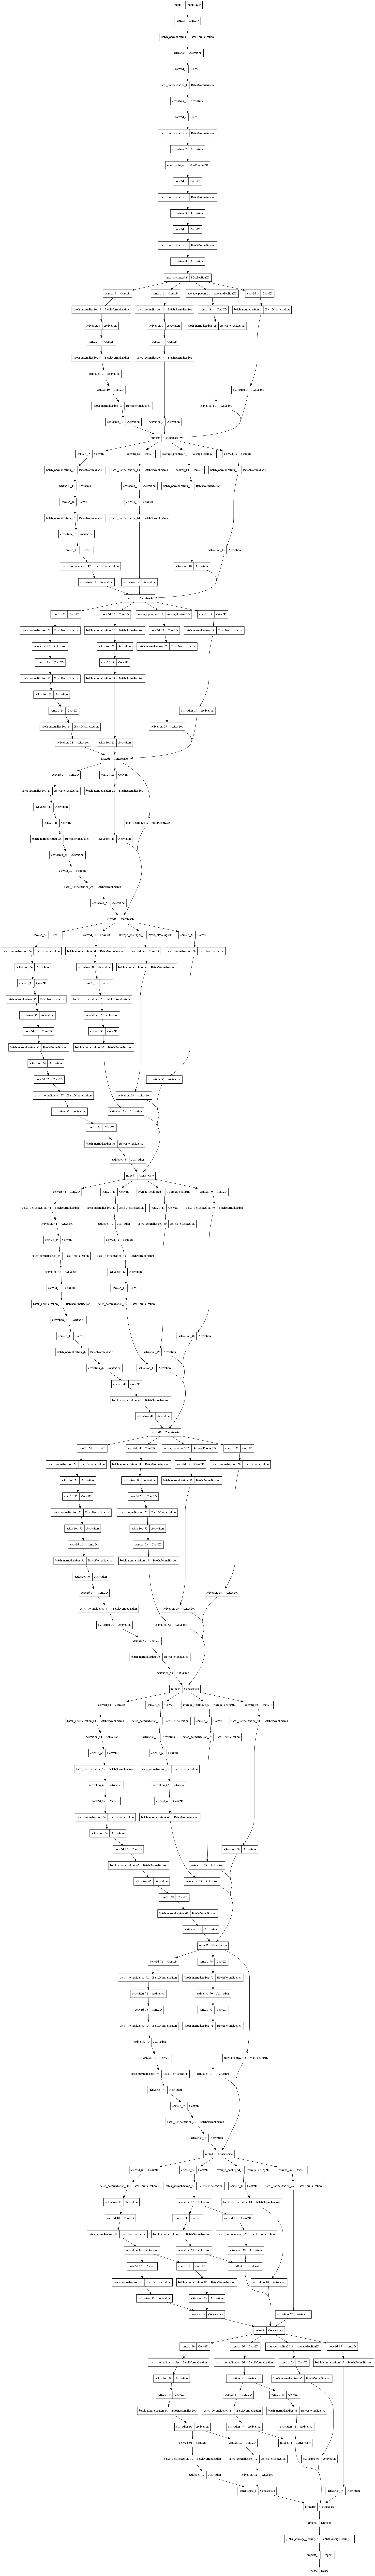

In [4]:
plot_model(new_model)

In [9]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [20]:
new_model.fit(train_ds, validation_data = val_ds, epochs=2, steps_per_epoch=300, verbose = 1, callbacks=callbacks)

Epoch 1/2
300/300 [==============================] - ETA: 0s - loss: 1.3644 - accuracy: 0.5098
Epoch 1: val_accuracy improved from -inf to 0.53573, saving model to checkpoints_2


INFO:tensorflow:Assets written to: checkpoints_2\assets


INFO:tensorflow:Assets written to: checkpoints_2\assets


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 96: invalid continuation byte

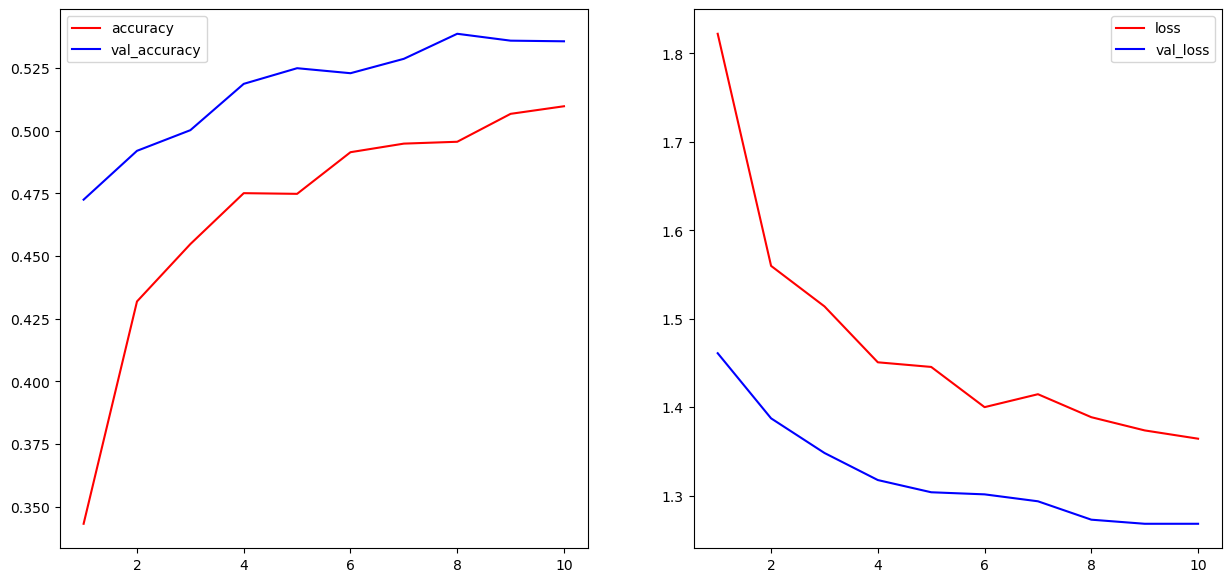

In [21]:
log = np.genfromtxt('log.csv',delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()

## Fine-tuning

In [9]:
for layer in new_model.layers:
  layer.trainable = True

In [10]:
fine_tune = len(new_model.layers) - 39 #39 mixed_9 6.1M   #67 mixed_8 11.1M  #87 mixed_7 12.8M

for layer in new_model.layers[:fine_tune]:
  layer.trainable = False

In [11]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [12]:
new_model.fit(train_ds, validation_data = val_ds, epochs=1, steps_per_epoch=501, verbose = 1, callbacks=callbacks)

501/501 [==============================] - ETA: 0s - loss: 1.3951 - accuracy: 0.4939
Epoch 1: val_accuracy improved from -inf to 0.53648, saving model to checkpoints_FT


INFO:tensorflow:Assets written to: checkpoints_FT\assets


INFO:tensorflow:Assets written to: checkpoints_FT\assets


501/501 [==============================] - 1095s 2s/step - loss: 1.3951 - accuracy: 0.4939 - val_loss: 1.2706 - val_accuracy: 0.5365


# Graphs

## CD

In [43]:
min(log[1:,3])

0.4800559878349304

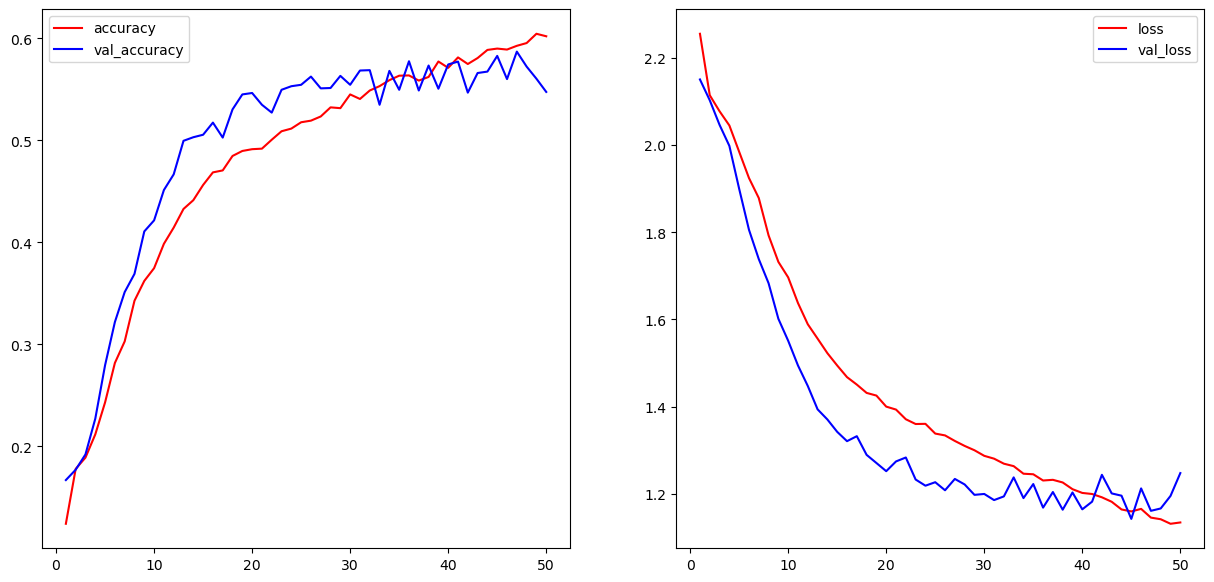

In [31]:
path = '../vast_checks/CD/CD_log.csv'
log = np.genfromtxt(path,delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()

In [3]:
path = '../vast_checks/TL_1d/TL_1d_checkpoints_FT/checkpoints/'
new_model = load_model(path) #softmax~

TypeError: SparseCategoricalCrossentropy.__init__() got an unexpected keyword argument 'ignore_class'

## ResNet

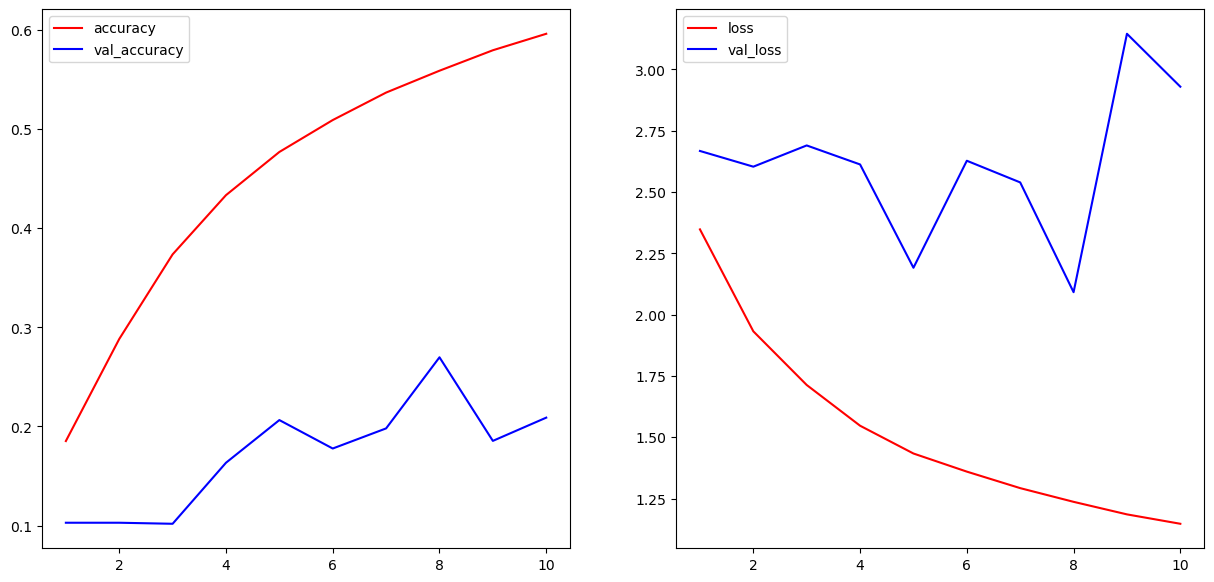

In [33]:
path = '../vast_checks/RN_3stacks/RN_log_3stacks.csv'
log = np.genfromtxt(path,delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()

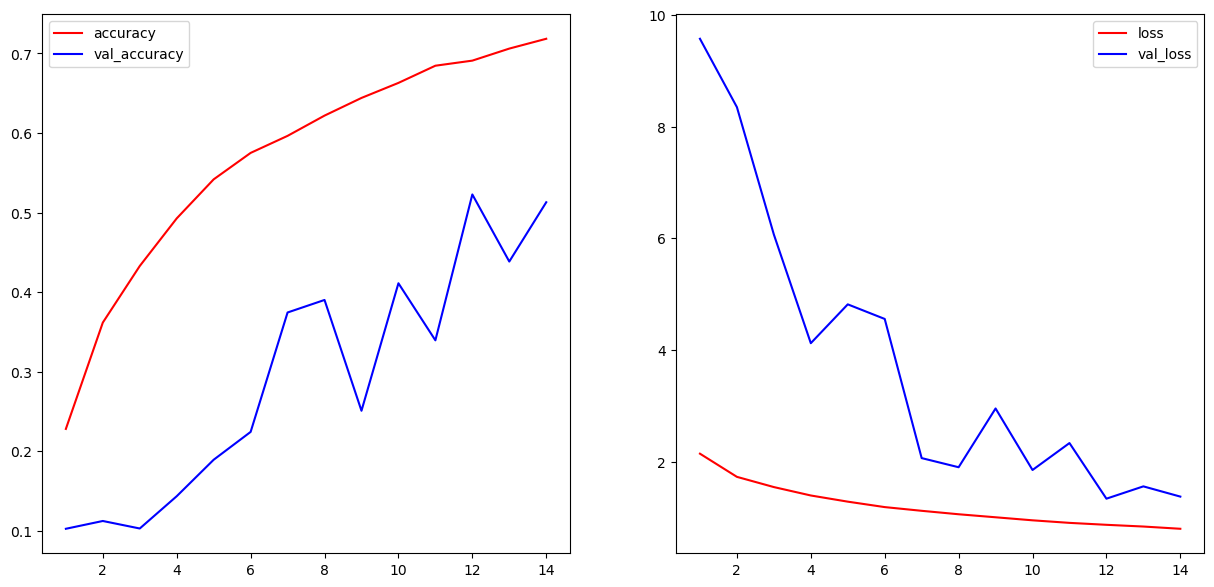

In [35]:
path = '../vast_checks/RN_4stacks/RN_log_4stacks.csv'
log = np.genfromtxt(path,delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()

## TL (Inception v3)

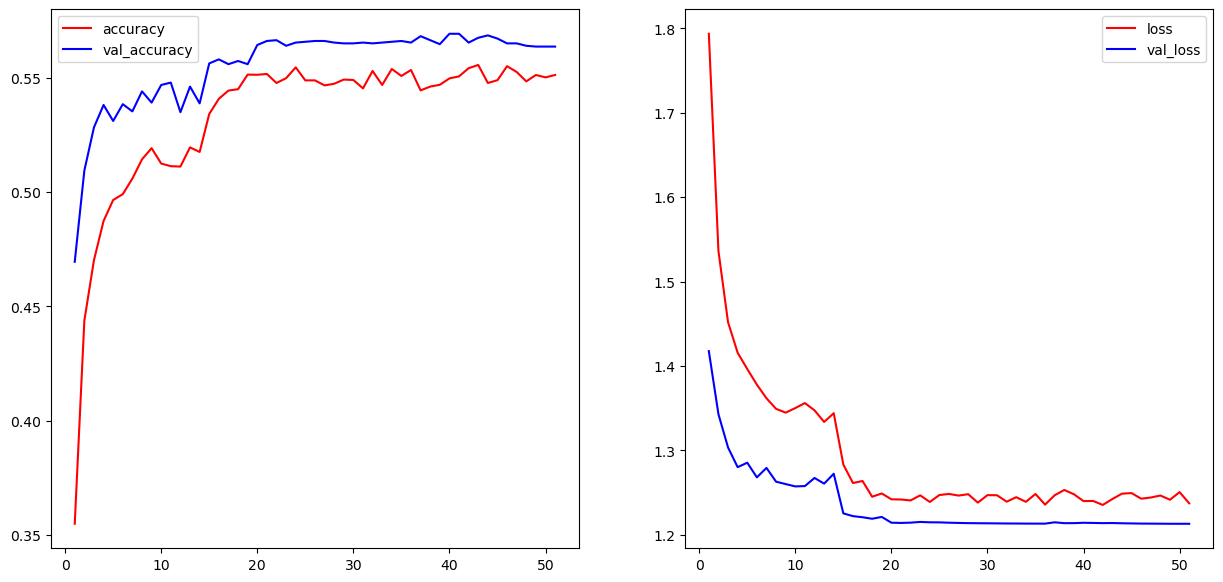

In [38]:
path = '../vast_checks/TL_1d/TL_1d_log.csv'
log = np.genfromtxt(path,delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()

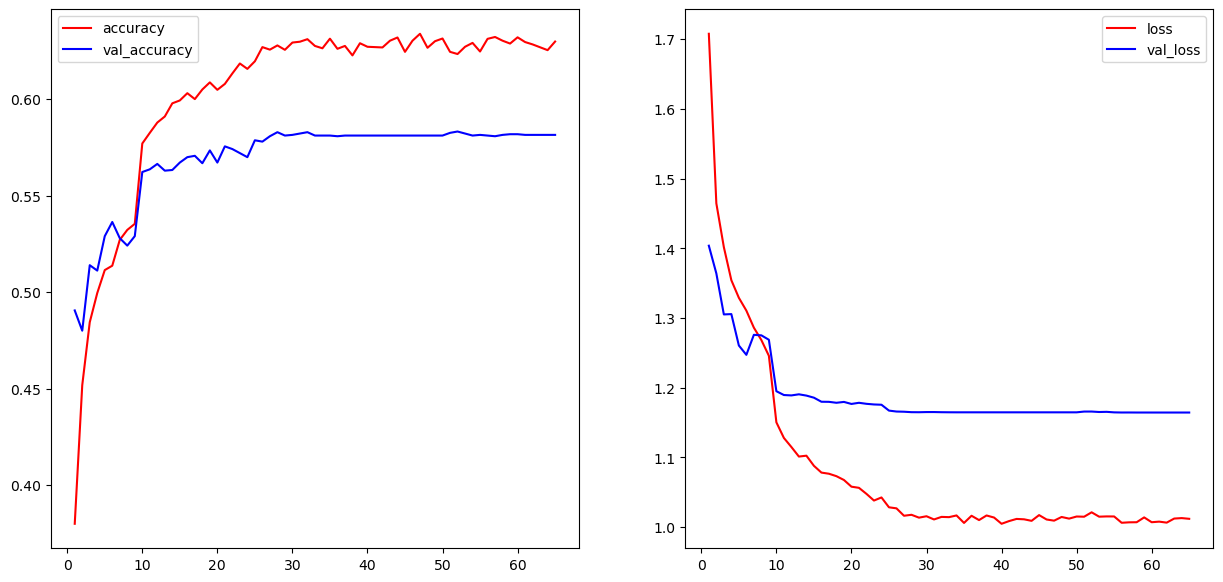

In [41]:
path = '../vast_checks/TL_2d/TL_2d_log_FT.csv'
log = np.genfromtxt(path,delimiter=',')

l = len(log)-1

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(np.arange(l)+1,log[1:,1], c='r')
plt.plot(np.arange(l)+1,log[1:,3], c='b')
plt.legend(['accuracy','val_accuracy'])

plt.subplot(122)
plt.plot(np.arange(l)+1,log[1:,2], c='r')
plt.plot(np.arange(l)+1,log[1:,4], c='b')
plt.legend(['loss','val_loss'])
plt.show()